In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from neurodsp import filt
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.plts.spectral import plot_power_spectra

from scipy import signal

from sklearn.decomposition import FastICA, PCA





In [2]:
Pkl_Filename = 'raw_data_recording-8ch.pkl'
Pkl_Filename_2 = 'raw_data_recording-8ch-2.pkl'
data = []
data_2 = []
with open(Pkl_Filename, 'rb') as file:
    data = pickle.load(file)
    
with open(Pkl_Filename_2, 'rb') as file:
    data_2 = pickle.load(file)
    
print(data)
print(data_2)

[array([[0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        8.60000000e+01, 8.70000000e+01, 8.80000000e+01],
       [0.00000000e+00, 2.02571848e+04, 2.02551508e+04, ...,
        2.14958515e+04, 2.12548549e+04, 2.04841668e+04],
       [0.00000000e+00, 9.69527032e+04, 9.67566784e+04, ...,
        9.55015833e+04, 9.58104173e+04, 9.66560732e+04],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.61473081e+09, 1.61473081e+09, 1.61473081e+09, ...,
        1.61473081e+09, 1.61473081e+09, 1.61473081e+09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), array([[8.90000000e+01, 9.00000000e+01, 9.10000000e+01, ...,
        4.10000000e+01, 4.20000000e+01, 4.30000000e+01],
       [2.03097785e+04, 2.13675748e+04, 2.13824834e+04, ...,
        2.10941683e+04, 2.15628620e+04, 2.16045927e+04],
       [9.66848399e+04, 9.56283400e+04, 9

In [3]:
def assemble_sort_raw_data(raw_data):
    sequenced_data = []
    for chunck in data:
        if len(sequenced_data) == 0:
            sequenced_data = chunck
        else:
            sequenced_data = np.concatenate((sequenced_data, chunck), axis=1)
        
    # sort by the time ch, 22 (brainflow)
    sorted_data = sequenced_data[:,sequenced_data[22].argsort()]
    sorted_data[22] = sorted_data[22] - min(sorted_data[22])
    
    return sorted_data

In [4]:
def get_event_list(sorted_data):
    event_list = []
    for i in range(sorted_data.shape[1]):
        e_label = sorted_data[23][i]
        e_time = sorted_data[22][i]
        if e_label != 0:
            event_list.append([e_label, e_time, i])
            
        
    return event_list

In [5]:
def filter_eeg(ch_datas, sample_rate, f_range):
    filtered = []
    for ch in ch_datas:
        sig_filt = filt.filter_signal(ch,sample_rate, 'bandpass', f_range, filter_type='iir', butterworth_order=2)
        test_filt = filt.filter_signal(sig_filt, sample_rate, 'bandstop', (58,62), n_seconds=1)
        num_nans = sum(np.isnan(test_filt))
        sig_filt = np.concatenate(([0]*(num_nans//2), sig_filt, [0]*(num_nans//2)))
        sig_filt = filt.filter_signal(sig_filt, sample_rate, 'bandstop', (58, 62), n_seconds=1)
        sig_filt = sig_filt[~np.isnan(sig_filt)]
        
        filtered.append(sig_filt)
    
    return np.array(filtered)

In [6]:
def plot_all_channels(ch_data):
    figure(figsize=(12,8))
    for ch in ch_data:
        plt.plot(ch)

In [7]:
raw_data = data+data_2
sorted_data = assemble_sort_raw_data(raw_data)

event_list = get_event_list(sorted_data)
ch_data = sorted_data[1:9]

In [19]:
ch_data = filter_eeg(ch_data, 250, (0.5,50))

/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/filter.py:96: UserWarning: Edge artifacts are not removed when using an IIR filter.
  warn('Edge artifacts are not removed when using an IIR filter.')
/Users/colinwageman/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


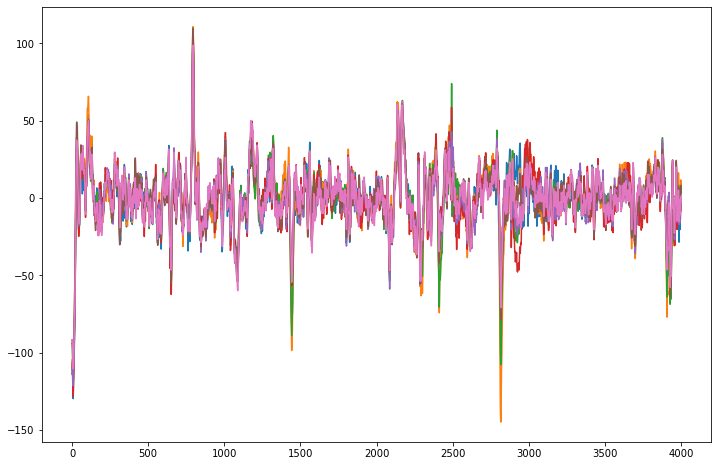

In [61]:
e_range = [2500, 6500]
plot_all_channels(ch_data[1:,e_range[0]:e_range[1]])

In [62]:
test = np.array([5,6,7], dtype=np.float64)
test -= np.mean(test)
test /= np.std(test)
test
# test / np.linalg.norm(test)
ch_data_T = ch_data[:,e_range[0]:e_range[1]].T
ch_data_T.shape
ch_data_T_2 = ch_data[:,e_range[1]:e_range[1]+250].T
import time

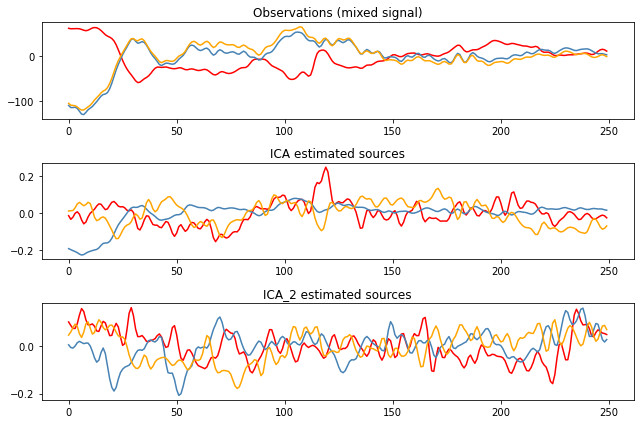

4.723747999378247


In [53]:
# compute ICA
ica = FastICA(n_components=4)
start_time = time.perf_counter() 
S_ = ica.fit_transform(ch_data_T)  # Get the estimated sources
end_time = time.perf_counter()
S_2 = ica.fit_transform(ch_data_T_2)
A_ = ica.mixing_  # Get estimated mixing matrix

# compute PCA
pca = PCA(n_components=4)
H = pca.fit_transform(ch_data_T)  # estimate PCA sources

plt.figure(figsize=(9, 6))

models = [ch_data_T, S_, S_2]
names = ['Observations (mixed signal)',
         'ICA estimated sources',
         'ICA_2 estimated sources']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()
print((end_time - start_time)*1000)

Populating the interactive namespace from numpy and matplotlib
[ 4.52902983e+02+0.00000000e+00j  3.55603941e+03+7.48842211e+02j
 -3.89096919e+03-6.88485636e+02j  2.30091977e+03-6.41826271e+02j
 -8.80773453e+02+9.13640255e+02j -2.81137142e+02+1.09737879e+02j
  1.78604473e+02-3.41179528e+02j -3.72783754e+02-2.69209461e+01j
 -1.71356697e+02+1.22058483e+02j  8.20247741e+01-2.01631028e+02j
 -3.96861380e+02+6.08616303e+02j -3.66153886e+02-2.60514096e+02j
  2.75292266e+02-1.84887568e+02j -6.94905482e+01+1.34557307e+02j
  8.72489728e+01-1.25372876e+02j  3.62727888e+01-8.87571659e+01j
 -1.24637794e+02+6.82207248e+01j  7.18676322e+01+1.26129720e+02j
  6.12823631e+00+4.79815833e+01j  2.28744285e+01+8.79745103e+00j
  2.63991296e+01-6.50030091e+01j -5.89885853e+01+7.21070364e+01j
  1.55536965e+02-1.02854217e+02j -1.39842799e+01+6.63557068e+01j
 -1.35631282e+02+1.25086025e+02j  1.05926610e+02+1.29246588e+02j
  9.08417741e+01-1.46444391e+02j -6.05080026e+01+2.44769052e+01j
  1.03830809e+01+5.48075311

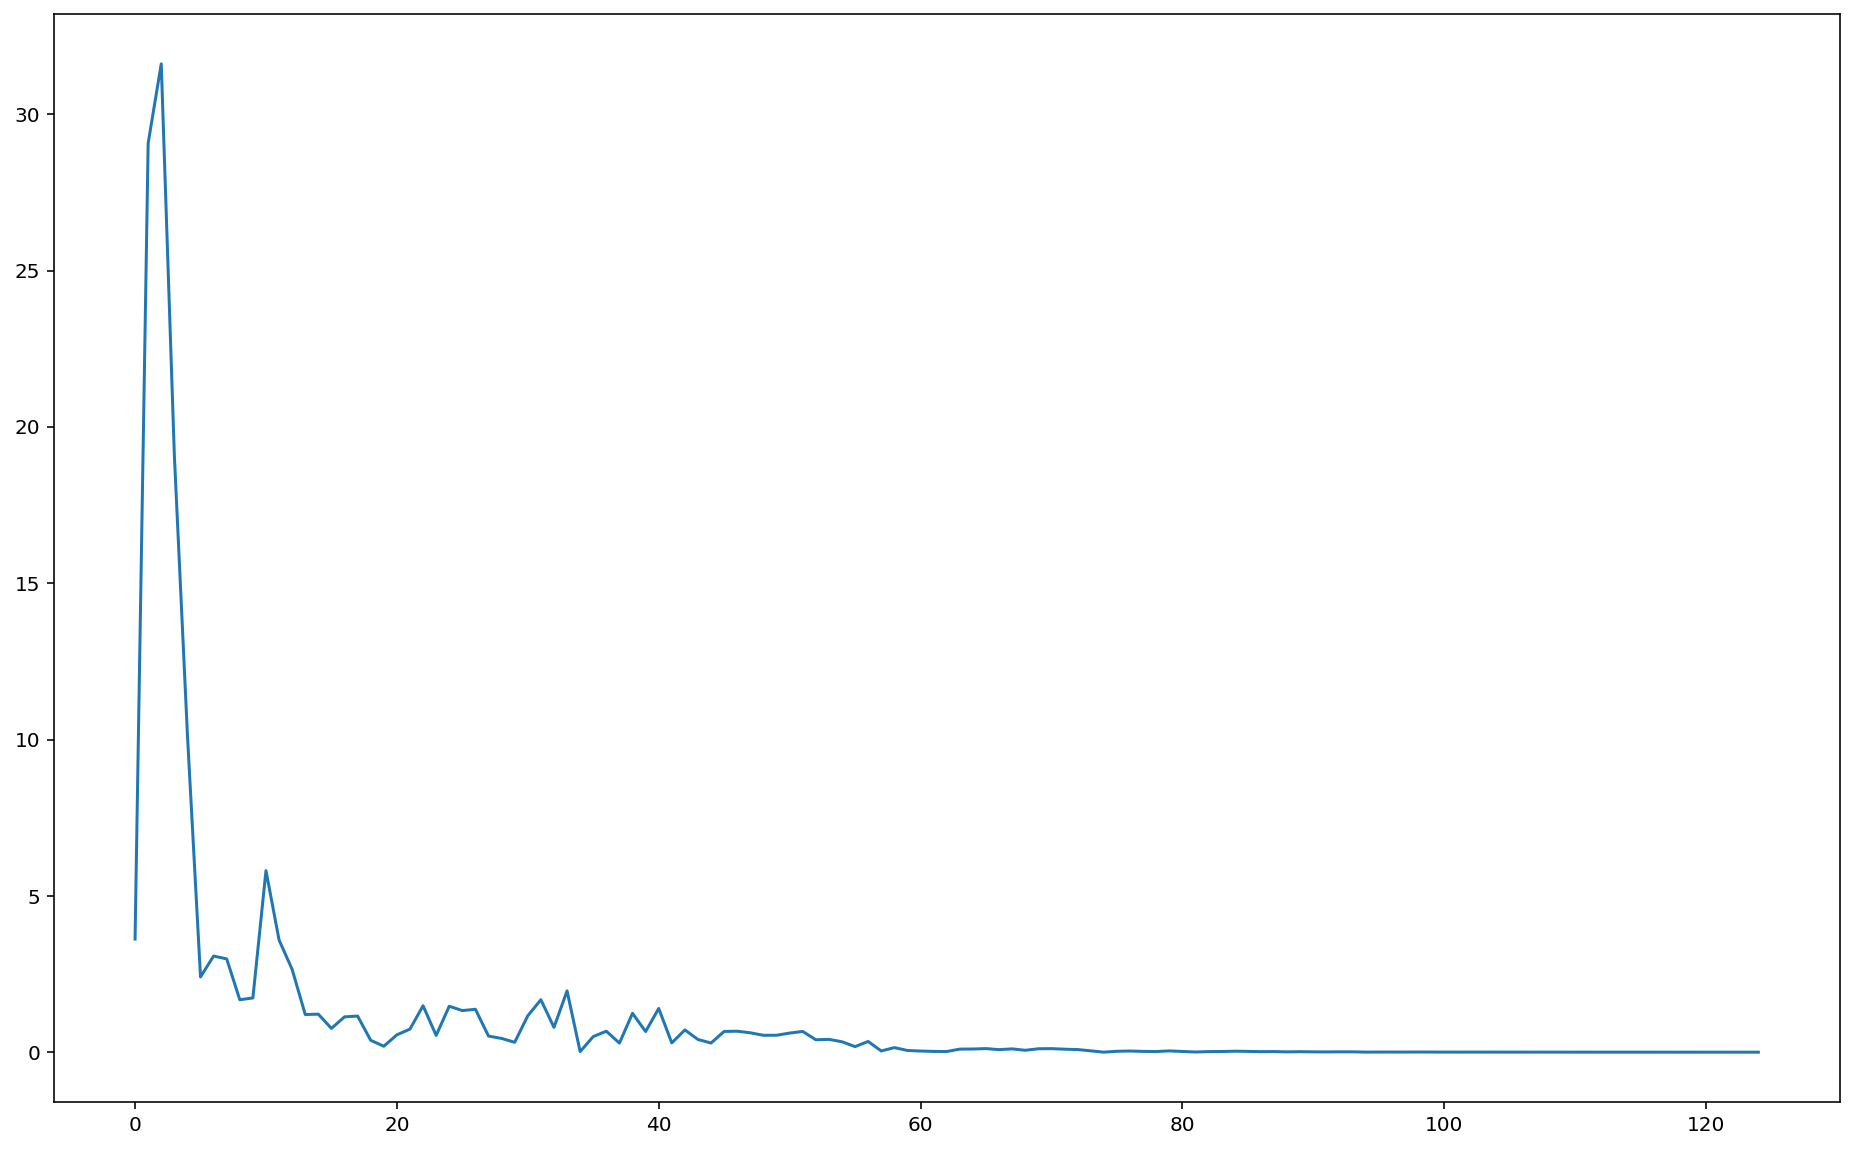

In [94]:
%config InlineBackend.figure_format = 'retina'
%pylab inline

def plot_ch_fft(ch_data):
    # Number of sampling points
    N = len(ch_data)
    # Sample spacing
    T = 1.0/250.0
#     x = np.linspace(0, N*T, N)
    fourier = np.fft.fft(ch_data)
    xf = np.linspace(0, 1//(2*T), N//2)
#     freq = np.fft.fftfreq(250)
    figure(figsize=(16,10))
#     plt.plot(freq, abs(fourier.real))
# ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
    print(fourier)
    print(2.0/N * np.abs(fourier[:N//2]))
    plt.plot(xf, 2.0/N * np.abs(fourier[:N//2]))
    
plot_ch_fft(ch_data[4][10500:10750])
# print(ch_data[4][2500:2750].shape)

Populating the interactive namespace from numpy and matplotlib
(4000,)
(2000,)


Text(0.5, 1.0, 'FFT of ECoG signal')

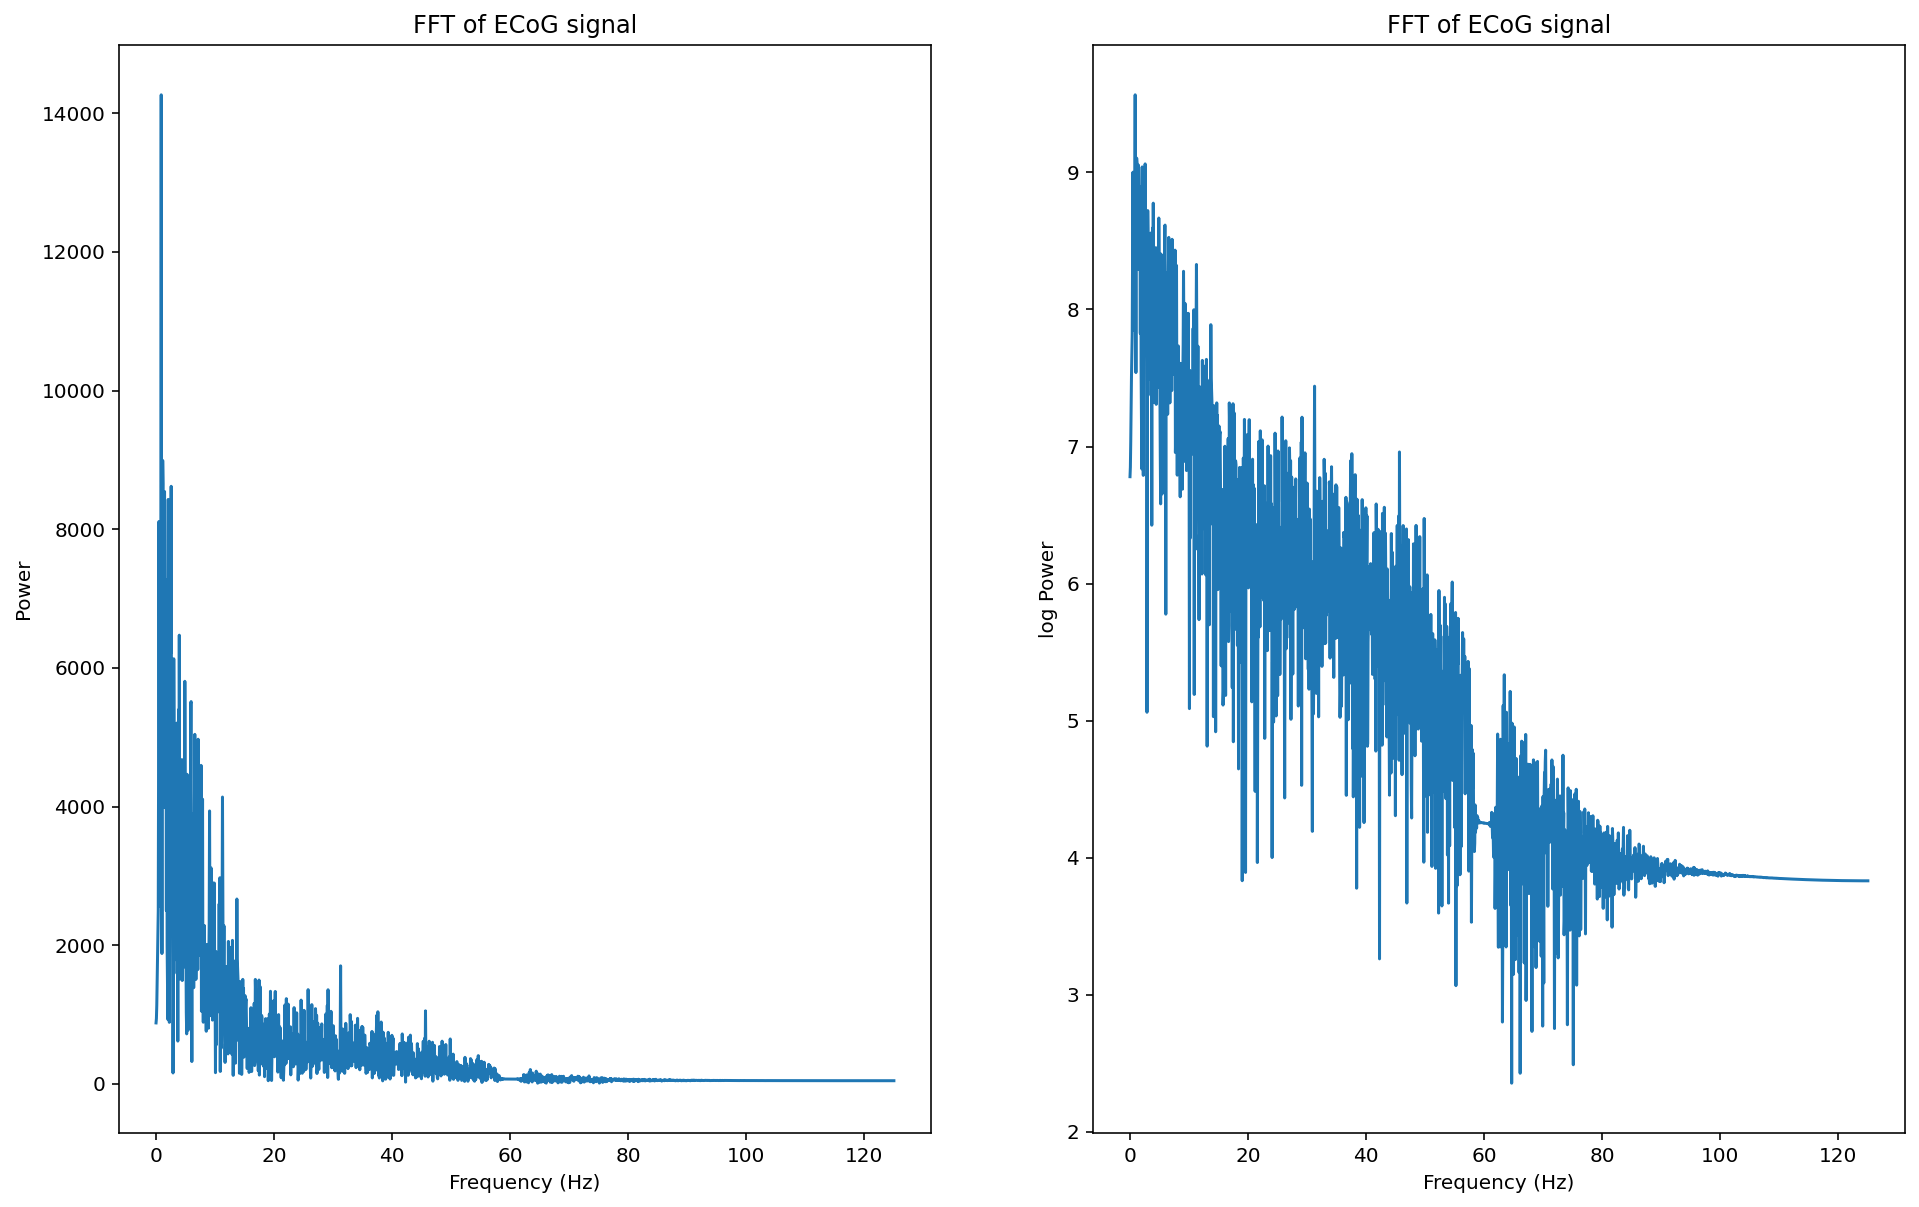

In [70]:
%config InlineBackend.figure_format = 'retina'
%pylab inline

ch_data_T = ch_data[:,e_range[0]:e_range[1]].T
fourier = np.fft.fft(ch_data_T[:,4])
fx_step_size = 250/len(ch_data_T)
nyq = .5*250
total_steps = int(nyq/fx_step_size)
print(ch_data_T[:,4].shape)
fx_bins = np.linspace(0, nyq, total_steps)
print(fx_bins.shape)

figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.plot(fx_bins[0:2000],abs(fourier[0:2000])) #any frequencies above 200 Hz are probably noise
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of ECoG signal')

plt.subplot(1,2,2)
plt.plot(fx_bins[0:2000],log(abs(fourier[0:2000]))) #any frequencies above 200 Hz are probably noise
plt.ylabel('log Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of ECoG signal')

(250,)


<BarContainer object of 4 artists>

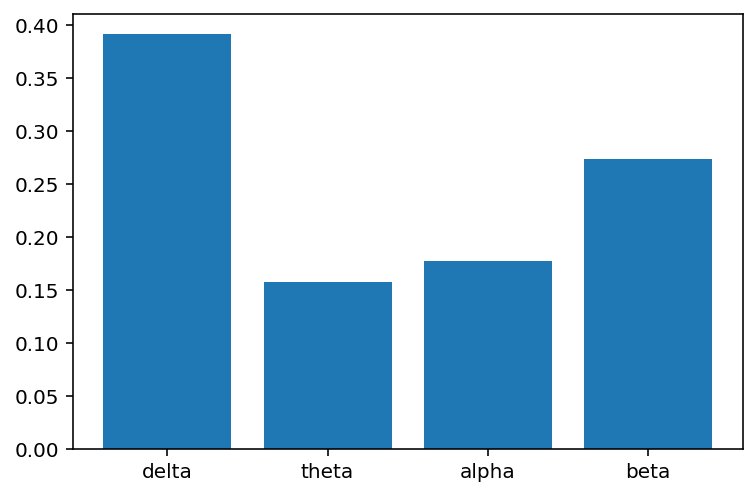

In [126]:
import pyeeg

X = ch_data[4,5000:6000].T
print(ch_data_T.shape)
bins = [0.5,4,7,12,30] # delta, theta, alpha and beta

power, power_ratio = pyeeg.bin_power(X, bins, 250.0)
p_r = np.array(power_ratio)
p = np.array(power)
plt.bar(['delta', 'theta', 'alpha', 'beta'],p_r)

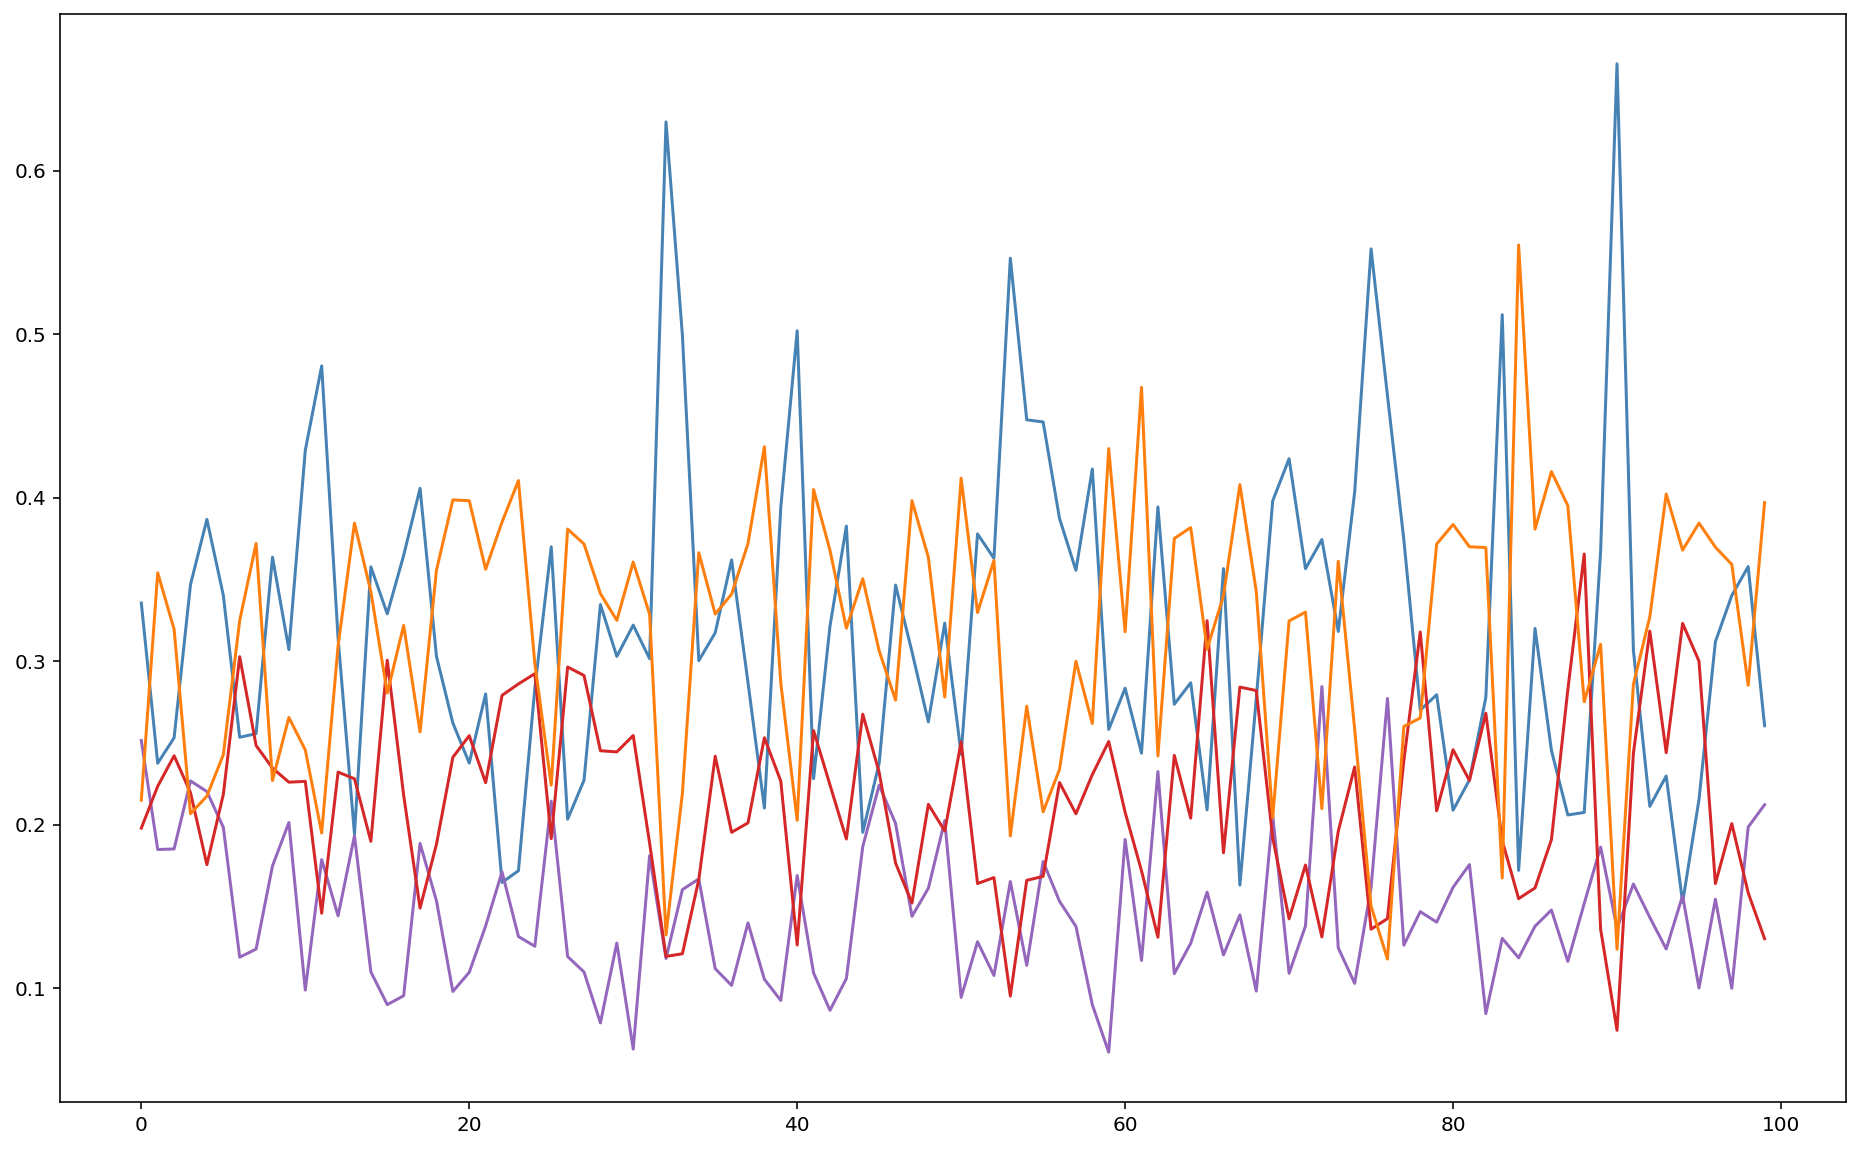

In [140]:
bins = [0.5,4,7,12,30] # delta, theta, alpha and beta
labels = ['delta', 'theta', 'alpha', 'beta']
samples = 100

acc = []
for i in range(samples):
    b = 2500
    X = ch_data[4,b+i*250:b+(i+1)*250].T
    power, power_ratio = pyeeg.bin_power(X, bins, 250.0)
    acc.append(np.array(power_ratio))
    
acc = np.array(acc).T
xrange = np.arange(0,samples)
figure(figsize=(16,10))
plt.plot(xrange, acc[0], color='steelblue')
plt.plot(xrange, acc[1], color='tab:purple')
plt.plot(xrange, acc[2], color='tab:red')
plt.plot(xrange, acc[3], color='tab:orange')